In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import os

from sklearn import preprocessing as pp

from yahoo_fin import stock_info as si
import talib as tlb

# Price prediction

![logo](jupyter_logo.png)

# Utilisation du GPU

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17014453418023344500
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4112973824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1193734625003299353
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Importation des données

In [5]:
possible_features = ['open', 'high', 'low', 'close', 'volume', 'close 7 days mean', 'close 14 days mean', 'close 20 days mean', 'close 50 days mean', 'ema', 'upperband', 'middleband', 'lowerband', 'rsi', 'macd', 'bop', 'obv', 'natr', 'sine', 'leadsine', 'CDLKICKINGBYLENGTH', 'CDLTAKURI', 'CDLHARAMI', 'CDLDOJI', 'CDLDRAGONFLYDOJI', 'CDLLONGLEGGEDDOJI']

Paramètres

In [6]:
ticker = 'KO' #choix de l'action à étudier

n = 60 #nombre de jours considérés par le modèle précédant la date voulue
days_predicted = 2 #on prévoit le prix de l'action à la date t + days_predicted
test_size = 0.2 #part des données réservée au test du modèle
shffl = False
features = possible_features #liste d'indicateurs financiers utiles à la prédiction




Chargement de la dataset avec pandas

In [7]:
df = si.get_data(ticker) 
df.head()

,open,high,low,close,adjclose,volume,ticker
1970-03-25,0.828125,0.842448,0.828125,0.828125,0.192157,1862400,KO
1970-03-26,0.828125,0.837240,0.828125,0.834635,0.193667,854400,KO
1970-03-30,0.835938,0.846354,0.835938,0.838542,0.194574,1008000,KO
1970-03-31,0.837240,0.837240,0.829427,0.835938,0.193969,710400,KO
1970-04-01,0.835938,0.838542,0.833333,0.837240,0.194271,940800,KO


In [8]:
df.drop(columns=['ticker', 'adjclose'], inplace = True)
df = df.astype(np.float64)
df.head()

,open,high,low,close,volume
1970-03-25,0.828125,0.842448,0.828125,0.828125,1862400.0
1970-03-26,0.828125,0.837240,0.828125,0.834635,854400.0
1970-03-30,0.835938,0.846354,0.835938,0.838542,1008000.0
1970-03-31,0.837240,0.837240,0.829427,0.835938,710400.0
1970-04-01,0.835938,0.838542,0.833333,0.837240,940800.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13095 entries, 1970-03-25 to 2022-02-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    13095 non-null  float64
 1   high    13095 non-null  float64
 2   low     13095 non-null  float64
 3   close   13095 non-null  float64
 4   volume  13095 non-null  float64
dtypes: float64(5)
memory usage: 613.8 KB


Plot de certaines colonnes

<AxesSubplot:>

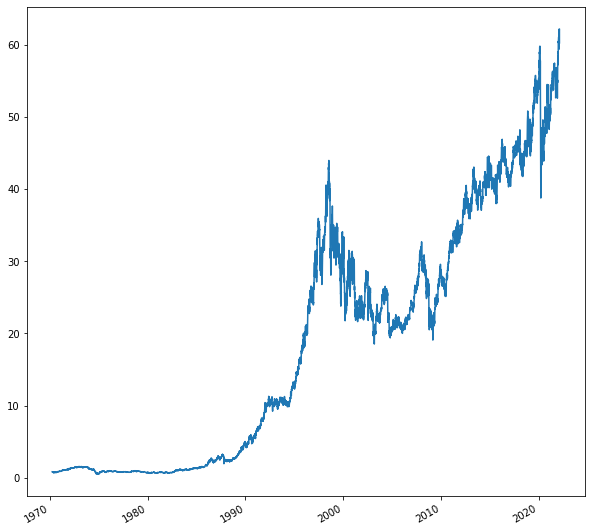

In [10]:
df['open'].plot(figsize = (10, 10))

In [11]:
df.dropna(inplace = True)

In [12]:
df.shape

(13095, 5)

# Calibrage de la fenêtre 

Pour certaines action, le cours ne se comporte pas du tout pareil selon la période, il faut ajuster la fenêtre, en selectionnant la durée souhaitée avec la commande  
``` 
df = df.iloc[n_supp:,:] 
``` 

où n_supp est le nombre de jours supprimés. Cet ajustement est à faire manuellement pour chaque action, dans le cas du btc, on garde tout car la période 
est assez récente.


In [13]:
df = df.iloc[8000:,:]

# Indicateurs d'analyse technique

yahoo_fin permet uniquement d'obtenir les 5 colonnes 'adjclose', 'volume', 'open', 'high', 'low', on rajoute donc nos features


In [14]:
########Overlap Studies Functions

#Moyennes mobiles :
#7j
df['close 7 days mean'] = df['close'].rolling(window = 7).mean()
#14j
df['close 14 days mean'] = df['close'].rolling(window = 14).mean()
#20j
df['close 20 days mean'] = df['close'].rolling(window = 20).mean()
#50j
df['close 50 days mean'] = df['close'].rolling(window = 50).mean()


df['ema'] = tlb.EMA(df['close'], timeperiod=30)

df['upperband'], df['middleband'], df['lowerband'] = tlb.BBANDS(df['close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)



In [15]:
#######Momentum Indicator Functions : 

#RSI
df['rsi'] = tlb.RSI(df['close'], timeperiod=14)

#MACD
df['macd'], df['macdsignal'], df['macdhist'] = tlb.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

#balance of power
df['bop'] = tlb.BOP(df['open'], df['high'], df['low'], df['close']) #balance of power

In [16]:
##########Volume Indicator Functions

df['obv'] = tlb.OBV(df['close'], df['volume']) #on balance volume

In [17]:
##########Volatility Indicator Functions

df['natr'] = tlb.NATR(df['high'], df['low'], df['close'], timeperiod=14) #Normalized Average True Range

In [18]:
###########Cycle Indicator Functions très important apparament

df['sine'], df['leadsine'] = tlb.HT_SINE(df['close'])

In [19]:
###########Patern Recognition

df['CDLKICKINGBYLENGTH'] = tlb.CDLKICKINGBYLENGTH(df['open'], df['high'], df['low'], df['close']) #bull / bear
df['CDLTAKURI'] = tlb.CDLTAKURI(df['open'], df['high'], df['low'], df['close'])
df['CDLHARAMI'] = tlb.CDLHARAMI(df['open'], df['high'], df['low'], df['close'])
df['CDLDOJI'] = tlb.CDLDOJI(df['open'], df['high'], df['low'], df['close'])
df['CDLDRAGONFLYDOJI'] = tlb.CDLDRAGONFLYDOJI(df['open'], df['high'], df['low'], df['close'])
df['CDLLONGLEGGEDDOJI'] = tlb.CDLLONGLEGGEDDOJI(df['open'], df['high'], df['low'], df['close'])

In [51]:
df.head()

,open,high,low,close,volume,close 7 days mean,close 14 days mean,close 20 days mean,close 50 days mean,ema,...,natr,sine,leadsine,CDLKICKINGBYLENGTH,CDLTAKURI,CDLHARAMI,CDLDOJI,CDLDRAGONFLYDOJI,CDLLONGLEGGEDDOJI,futur
2002-02-27,0.112907,0.117901,0.112568,0.118282,0.049219,0.108061,0.093473,0.082156,0.074378,0.079308,...,0.206689,0.482840,0.134521,0.0,0.0,0.5,0.0,0.0,0.0,0.128849
2002-02-28,0.123796,0.118128,0.118892,0.117259,0.052112,0.109908,0.094761,0.084300,0.074665,0.080240,...,0.199334,0.521537,0.162004,0.0,0.0,0.5,0.0,0.0,0.0,0.121577
2002-03-01,0.113022,0.123239,0.114407,0.128849,0.057044,0.112477,0.096944,0.087122,0.075232,0.081919,...,0.203436,0.523058,0.163127,0.0,0.0,0.5,0.0,0.0,0.0,0.119645
2002-03-04,0.126204,0.122672,0.117167,0.121577,0.058180,0.115449,0.098334,0.088994,0.075551,0.082983,...,0.211305,0.550083,0.183639,0.0,0.0,0.0,0.0,0.0,0.0,0.118964
2002-03-05,0.119441,0.117219,0.117742,0.119645,0.053700,0.115952,0.099605,0.090762,0.075579,0.083843,...,0.204473,0.056885,0.022888,0.0,0.0,0.5,1.0,0.0,1.0,0.112260


## Affiche de certains indicateurs
Affichage des indicateurs

<AxesSubplot:>

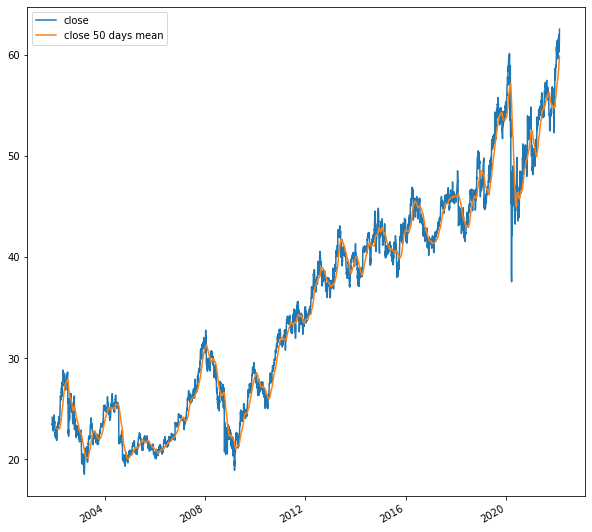

In [22]:
df[['close', 'close 50 days mean']].plot(figsize = (10, 10))

<AxesSubplot:>

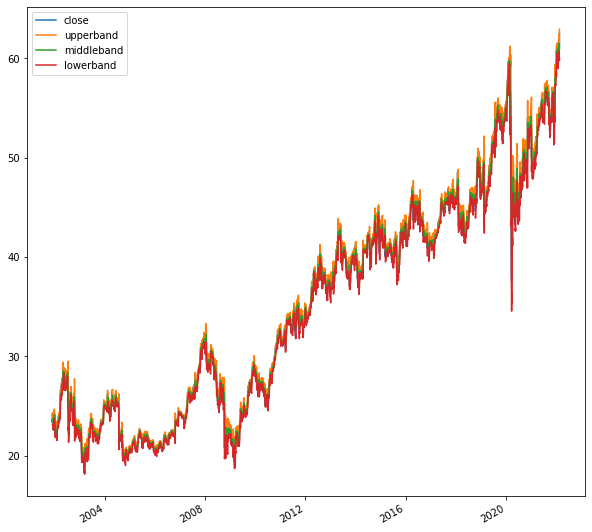

In [23]:
df[['close', 'upperband', 'middleband', 'lowerband']].plot(figsize = (10, 10))

# Pre-processing

/!\ il faut bien sauvegarder le scaler, car il dépend du min et du max de la colonne !, on ne pourra pas de-scale après sinon

In [24]:
scaler_dict = {}

for column in features:
    scaler = pp.MinMaxScaler()
    df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
    #on conserve le scaler de chaque colonne car il dépend de la colonne
    scaler_dict[column] = scaler
    
    
    
    

In [25]:
scaler_dict

{'open': MinMaxScaler(),
 'high': MinMaxScaler(),
 'low': MinMaxScaler(),
 'close': MinMaxScaler(),
 'volume': MinMaxScaler(),
 'close 7 days mean': MinMaxScaler(),
 'close 14 days mean': MinMaxScaler(),
 'close 20 days mean': MinMaxScaler(),
 'close 50 days mean': MinMaxScaler(),
 'ema': MinMaxScaler(),
 'upperband': MinMaxScaler(),
 'middleband': MinMaxScaler(),
 'lowerband': MinMaxScaler(),
 'rsi': MinMaxScaler(),
 'macd': MinMaxScaler(),
 'bop': MinMaxScaler(),
 'obv': MinMaxScaler(),
 'natr': MinMaxScaler(),
 'sine': MinMaxScaler(),
 'leadsine': MinMaxScaler(),
 'CDLKICKINGBYLENGTH': MinMaxScaler(),
 'CDLTAKURI': MinMaxScaler(),
 'CDLHARAMI': MinMaxScaler(),
 'CDLDOJI': MinMaxScaler(),
 'CDLDRAGONFLYDOJI': MinMaxScaler(),
 'CDLLONGLEGGEDDOJI': MinMaxScaler()}

In [26]:
df.head()

,open,high,low,close,volume,close 7 days mean,close 14 days mean,close 20 days mean,close 50 days mean,ema,...,obv,natr,sine,leadsine,CDLKICKINGBYLENGTH,CDLTAKURI,CDLHARAMI,CDLDOJI,CDLDRAGONFLYDOJI,CDLLONGLEGGEDDOJI
2001-11-26,0.135832,0.130509,0.127515,0.127713,0.048434,NaN,NaN,NaN,NaN,NaN,...,0.121440,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2001-11-27,0.128496,0.122444,0.120731,0.124077,0.041919,NaN,NaN,NaN,NaN,NaN,...,0.119121,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2001-11-28,0.115887,0.111086,0.109923,0.109988,0.056780,NaN,NaN,NaN,NaN,NaN,...,0.116223,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2001-11-29,0.112907,0.109950,0.108658,0.113737,0.040968,NaN,NaN,NaN,NaN,NaN,...,0.118505,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2001-11-30,0.113480,0.109609,0.112108,0.112374,0.039565,NaN,NaN,NaN,NaN,NaN,...,0.116277,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0


Creation des targets

In [28]:
df['futur'] = df['close'].shift(-days_predicted)

In [29]:
df.shape

(5095, 29)

Ici, on supprime de nouveau les NaN, créés lors du calcul des indicateurs

In [30]:
df.dropna(inplace = True)

In [31]:
df.shape

(5030, 29)

## On shuffle y et c de la même manière

Préparation des séquences de prix des 50 derniers jours que l'on va considérer

In [32]:
sequence_tot = []
sequence = []
i = 0
for input_, tgt, current in zip(df[features].values, df['futur'].values, df['close'].values):
    sequence.append(input_)
    if len(sequence) == n: #dès que len(sequence) = n, on stock la sequence dans sequence_tot
                            #dès lors, on supprime le premier élément de sequence, et on ajoute l'entrée à la fin, 
                            #ça garde une séquence de 50
        sequence_tot.append([np.array(sequence), tgt, current])
        sequence.pop(0)


#tous les n, on ajoute tgt = target, avec df['futur'] qui est décalé de days_predicted 
#donc avec les n valeurs des nb_features features, on va essayer de trouver la target 


    
x_data, y_data = [], [] #c correspond à current, c'est le prix à la date considérée, on en aura besoin pour déterminer le bénéfice
#y est la donnée à déterminer, à savoir le prix à t + 10
for s, tgt, current in sequence_tot:
    x_data.append(s)
    y_data.append((tgt, current))
x_data, y_data = np.array(x_data), np.array(y_data)


In [33]:
y_data.shape

(4971, 2)

## Création de x, y, c sans sklearn

/!\ Ne pas lancer cette cellule si l'on cree x, y, c avec sklearn

In [ ]:
sequence_tot = []
sequence = []
i = 0
for inpt, tgt, current in zip(df[features].values, df['futur'].values, df['close'].values):
    sequence.append(inpt)
    if len(sequence) == n: #dès que len(sequence) = n, on stock la sequence dans sequence_tot
                            #dès lors, on supprime le premier élément de sequence, et on ajoute l'entrée à la fin, 
                            #ça garde une séquence de 50
        sequence_tot.append([np.array(sequence), tgt, current])
        sequence.pop(0)


#tous les n, on ajoute tgt = target, avec df['futur'] qui est décalé de days_predicted 
#donc avec les n valeurs des nb_features features, on va essayer de trouver la target 
#donc, si n=50 et days_predicted=10, last_sequence devrait être de longueur 60 (50+10)


    
x_data, y_data, c_data = [], [], [] #c correspond à current, c'est le prix à la date considérée, on en aura besoin pour déterminer le bénéfice
#y est la donnée à déterminer, à savoir le prix à t + 10
for s, tgt, current in sequence_tot:
    x_data.append(s)
    y_data.append(tgt)
    c_data.append(current)
x_data, y_data, c_data = np.array(x_data), np.array(y_data), np.array(c_data)


In [ ]:
idx = int((1 - test_size) * len(x_data))
          
x_train = x_data[:idx] #"""on prend les premiers pour le train"""
y_train = y_data[:idx] #"""on prend les premiers pour le train"""
x_test  = x_data[idx:] #"""on prend les derniers pour le test"""
y_test = y_data[idx:] #"""on prend les derniers pour le test"""
c_test = c_data[idx:]

# Création de x, y, c avec sklearn

In [34]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_data, y_data, test_size=test_size, shuffle=shffl)

In [36]:
y_test, c_test = y_test[:,0], y_test[:,1]

On a pas besion de c_train, on a juste besoin de c_test pour calculer les benefices, on garde juste y_train

In [37]:
y_train = y_train[:,0]

## Conversion en float64

Nous préférons utiliser les float64 plutôt que les float32 par défaut.

In [38]:
x_train = np.asarray(x_train).astype('float64')
y_train = np.asarray(y_train).astype('float64')
x_test = np.asarray(x_test).astype('float64')
y_test = np.asarray(y_test).astype('float64')

In [39]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3976, 60, 26), (3976,), (995, 60, 26), (995,))

In [40]:
df.tail(days_predicted)

,open,high,low,close,volume,close 7 days mean,close 14 days mean,close 20 days mean,close 50 days mean,ema,...,natr,sine,leadsine,CDLKICKINGBYLENGTH,CDLTAKURI,CDLHARAMI,CDLDOJI,CDLDRAGONFLYDOJI,CDLLONGLEGGEDDOJI,futur
2022-02-15,0.972260,0.976374,0.968725,0.962959,0.092294,0.993721,0.993075,0.995930,0.989734,0.993130,...,0.175037,0.765026,0.387600,0.0,0.0,0.5,1.0,0.0,1.0,0.990456
2022-02-16,0.969968,0.967742,0.967115,0.962732,0.109303,0.991370,0.995207,0.995809,0.992743,0.994007,...,0.169524,0.641804,0.261234,0.0,0.0,0.5,1.0,0.0,1.0,1.000000


# Modèle

In [41]:
#paramètres sur les données
n = 60
days_predicted = 2
test_size = 0.2
features = possible_features

#paramètres du modèle
nb_neurons = 256
nb_layers = 6
dropout = 0.4 #"désactive" aléatoirement certains neurones a chaque forward pour réduire l'overfitting
nb_features = len(features) #len de la dataframe
loss_fn = 'huber_loss'
e = 350 #nombre d'epoch
b_s = 32 #c'est la taille du batch
bidi = False
mtrcs = ['mean_absolute_error']
optm = 'adam'
activation_fn = 'tanh'
reg = None


In [42]:
def mod_name(ticker, n, days_predicted, test_size, nb_neurons, nb_layers, dropout, nb_features, loss_fn, e, b_s, bidi, mtrcs, optm, activation_fn, reg):
    return 'n' + str(n) + '__' + 'days_predicted' + str(days_predicted) + '__' + 'test_size' + str(test_size) + '__' + 'nb_neurons' + str(nb_neurons) + '__' + 'nb_layers' + str(nb_layers) + '__' + 'dropout' + str(dropout) + '__' + 'nb_features' + str(nb_features) + '__' + 'loss_fn' + str(loss_fn) + '__' + 'e' + str(e) + '__' + 'b_s' + str(b_s) + '__' + 'bidi' + str(bidi) + '__' + 'mtrcs' + str(mtrcs) + '__' + 'optm' + str(optm) + '__' + 'activation_fn' + str(activation_fn) + '__' + 'reg' + str(reg) 


In [43]:
name = mod_name(ticker, n, days_predicted, test_size, nb_neurons, nb_layers, dropout, nb_features, loss_fn, e, b_s, bidi, mtrcs, optm, activation_fn, reg)

In [44]:
name

"n60__days_predicted2__test_size0.2__nb_neurons256__nb_layers6__dropout0.4__nb_features26__loss_fnhuber_loss__e350__b_s32__bidiFalse__mtrcs['mean_absolute_error']__optmadam__activation_fntanh__regNone"

In [46]:
def mod(nb_neurons, nb_layers, dropout, n, nb_features, loss_fn, bidi, mtrcs, optm, activation_fn, reg):

    if bidi :
        """Bidirectionnel, n_layers = 2"""

        mod = tf.keras.Sequential()

        for _ in range(nb_layers - 1):
            mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(nb_neurons, 
                                                                       return_sequences=True, 
                                                                       batch_input_shape=(None, n, nb_features)
                                                                      )))
            mod.add(tf.keras.layers.Dropout(dropout))
        
        mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(nb_neurons, return_sequences=False)))
        mod.add(tf.keras.layers.Dropout(dropout))

        mod.add(tf.keras.layers.Dense(1, activation = activation_fn)) 
        mod.compile(loss = loss_fn, metrics = mtrcs, optimizer = optm)
        
        
    else :
        mod = tf.keras.Sequential()
        
        for _ in range(nb_layers - 1):
            mod.add(tf.keras.layers.LSTM(nb_neurons, return_sequences=True, batch_input_shape=(None, n, nb_features)))
            mod.add(tf.keras.layers.Dropout(dropout))
        
        mod.add(tf.keras.layers.LSTM(nb_neurons, return_sequences=False))
        mod.add(tf.keras.layers.Dropout(dropout))

        mod.add(tf.keras.layers.Dense(1, activation = activation_fn)) 
        mod.compile(loss = loss_fn, metrics = mtrcs, optimizer = optm) #adam est un algorithme d'optimisation (ADAptative Moment)

    return mod
        






In [47]:
mod = mod(nb_neurons, nb_layers, dropout, n, nb_features, loss_fn, bidi, mtrcs, optm, activation_fn, reg)

In [48]:
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 256)           289792    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 256)           5

In [49]:
"""création des dossiers pour les logs"""

if not os.path.isdir("logs"):
    os.mkdir("logs")


In [50]:
#on utilise tensorboard pour visualiser la loss etc au fil des epochs

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", name))

In [ ]:
mod.fit(x_train, y_train,
                    batch_size = b_s,
                    epochs = e,
                    validation_data = (x_test, y_test),
                    callbacks = [tensorboard],
                    verbose = 1)

Train on 3836 samples, validate on 959 samples
Epoch 1/350
3836/3836 [==============================] - 43s 11ms/sample - loss: 0.0039 - mean_absolute_error: 0.0492 - val_loss: 0.0028 - val_mean_absolute_error: 0.0570
Epoch 2/350
2944/3836 [======================>.......] - ETA: 5s - loss: 7.2295e-04 - mean_absolute_error: 0.0290

# Sauvegarde du modèle

In [62]:
mod.save(name + '.h5')

# Chargement d'un modèle déjà existant

Cette cellule permet de charger un modèle déjà entrainé

In [ ]:
loaded = tf.keras.models.load_model('BTC-USD__BiDiFalse__n60__days_predicted10__test_size0.2__nb_neurons256__dropout0.4__nb_features26__e650__b_s32.h5')

# Calcul des prédictions

In [82]:
y_pred = mod.predict(x_test)

In [83]:
y_pred.shape

(463, 1)

In [84]:
y_test.shape

(463, 1)

In [85]:
"""on met y_test sous la meme shape que y_pred pour la suite"""

'on met y_test sous la meme shape que y_pred pour la suite'

In [87]:
y_test = np.reshape(y_test, (y_pred.shape))

In [88]:
y_test.shape

(463, 1)

In [89]:
c_test = np.reshape(c_test, (y_pred.shape))

In [90]:
c_test.shape

(463, 1)

## On 'un-scale' les sortie pour comparer les prix en USD

In [92]:
#Une fois les données obtenues, on "descale" les prix pour trouver les vraies valeurs
y_test_descaled = np.squeeze(scaler_dict['close'].inverse_transform(y_test))
y_pred_descaled = np.squeeze(scaler_dict['close'].inverse_transform(y_pred))
c_test_descaled = np.squeeze(scaler_dict['close'].inverse_transform(c_test))

In [74]:
buy_profit  = lambda current, true_futur, pred_futur: true_futur - current if pred_futur > current else 0
sell_profit = lambda current, true_futur, pred_futur: current - true_futur if pred_futur < current else 0
#la gestion de portefeuille n'est pas l'objet de ce projet : on achete une unité d'action (ou de bitcoin ici), et on revend également une unité, independament de ce que cela représente comme part de notre capital.
#la stratégie d'investissement est basique : si on s'attend à ce que les prix augmentent, on achète (dans l'optique de revendre après)
#si on s'attend à ce que les prix diminuent, on vend (et on achète après)

# Calcul des profits

In [93]:
buy_prft = list(map(buy_profit, 
                                c_test_descaled, 
                                y_test_descaled, 
                                y_pred_descaled)
                                
                                )

sell_prft = list(map(sell_profit, 
                                c_test_descaled, 
                                y_test_descaled, 
                                y_pred_descaled)
                                )

In [94]:
buy_prft

[124.829833984375,
 -11.445999145507812,
 45.646972656249886,
 6.464996337890625,
 19.222000122070312,
 0,
 0,
 0,
 -22.56201171875,
 14.152008056640625,
 25.41064453125,
 -23.0369873046875,
 0,
 -9.884994506835938,
 1174.0400390625,
 3467.1328125,
 9.188003540039062,
 913.2099609375,
 16.409011840820312,
 5247.71484375,
 13.33447265625,
 2776.533203125,
 102.87890625,
 0,
 0,
 610.384765625,
 122.85400390625,
 0,
 0,
 0,
 0,
 -24.9739990234375,
 91.18801879882812,
 -56.486328125,
 337.4580078125,
 33.98799133300781,
 2811.65234375,
 -29.1199951171875,
 0,
 4.52301025390625,
 -255.97509765625,
 0,
 11.871002197265625,
 852.60791015625,
 0,
 0,
 320.5166015625,
 10552.068359375,
 0,
 0,
 21.10198974609375,
 3039.326171874998,
 31.891006469726562,
 0,
 22.836975097656136,
 -73.7998046875,
 0,
 0,
 1169.19921875,
 0,
 1585.4443359375,
 0,
 0,
 206.419921875,
 -2.22601318359375,
 110.85003662109375,
 0,
 244.92333984375,
 411.280029296875,
 -184.119140625,
 0,
 0.1820068359375,
 4829.625,


In [95]:
sell_prft

[0,
 0,
 0,
 0,
 0,
 43.0699462890625,
 61.1201171875,
 989.87939453125,
 0,
 0,
 0,
 0,
 83.83984375,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 975.81005859375,
 15077.05859375,
 0,
 0,
 289.9140625,
 285.759765625,
 2184.490234375,
 514.6125488281255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 315.2294921875,
 0,
 0,
 664.6123046875,
 0,
 0,
 245.5166015625,
 983.248046875,
 0,
 0,
 115.6552734375,
 342.14013671875,
 0,
 0,
 0,
 463.1098632812509,
 0,
 0,
 61.2041015625,
 -28.1640625,
 0,
 109.38037109375,
 0,
 547.7197265625,
 7.81201171875,
 0,
 0,
 0,
 1464.9501953125,
 0,
 0,
 0,
 -2.1594238281245453,
 0,
 0,
 0,
 0,
 -25.469970703125,
 5358.73046875,
 0,
 0,
 -97.5546875,
 0,
 1033.8779296875,
 9.47021484375,
 397.435546875,
 420.130859375,
 0,
 0,
 12.1710205078125,
 0,
 0,
 1011.5869140625,
 0,
 0,
 0,
 0,
 7161.859375,
 0,
 0,
 1599.19921875,
 -631.785400390625,
 0,
 0,
 -156.310546875,
 6.31500244140625,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -107.87646484375045,
 0,
 0,
 0,
 0,
 -47.4697265

On calcule l'accuracy en regardant la proportion de profit positif

In [96]:
accuracy = (len([e for e in sell_prft if e > 0]) + len([e for e in buy_prft if e > 0])) / len(y_pred)

In [97]:
tot_buy_profit  = sum(buy_prft)
tot_sell_profit = sum(sell_prft)
tot_profit = tot_buy_profit + tot_sell_profit
profit_per_trade = tot_profit / len(y_pred)

In [98]:
tot_profit, profit_per_trade

(408729.9564361572, 882.7860830154584)

In [81]:
accuracy

0.8099352051835853